In [2]:
BASE_DIR = {
    "test" : "/kaggle/input/breast-cancer-detection/test",
    "train" : "/kaggle/input/breast-cancer-detection/train",
    "valid" : "/kaggle/input/breast-cancer-detection/valid"
}

In [3]:
def count_images(base_path):
    counts = {}
    for cls in os.listdir(base_path):
        cls_path = os.path.join(base_path, cls)
        if os.path.isdir(cls_path):
            counts[cls] = len(os.listdir(cls_path))
    return counts

In [4]:
import os
# Store counts for all sets
counts_data = {name: count_images(path) for name, path in BASE_DIR.items()}

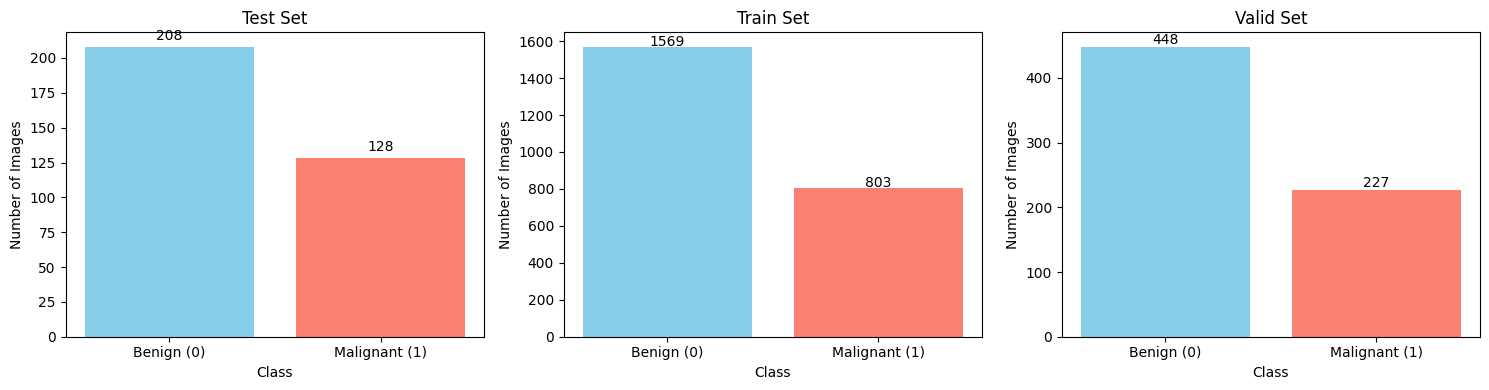

In [6]:
import matplotlib.pyplot as plt
# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, (split, counts) in enumerate(counts_data.items()):
    axes[i].bar(counts.keys(), counts.values(), color=['skyblue', 'salmon'])
    axes[i].set_title(f"{split.capitalize()} Set")
    axes[i].set_xlabel("Class")
    axes[i].set_ylabel("Number of Images")
    axes[i].set_xticks(list(counts.keys()))
    axes[i].set_xticklabels(["Benign (0)", "Malignant (1)"])
    for j, val in enumerate(counts.values()):
        axes[i].text(j, val + 5, str(val), ha='center')

plt.tight_layout()
plt.show()

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-11-01 09:00:46.267268: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761987646.490876      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761987646.559500      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [8]:
# Image size and batch size (you can adjust these)
IMG_SIZE = (224, 224)  # Common size for CNNs
BATCH_SIZE = 32


In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,            # normalize pixel values
    rotation_range=15,          # small rotation for augmentation
    width_shift_range=0.1,      
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [10]:
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
from sklearn.utils import shuffle
import pandas as pd
import os

data = []
for label in ['0', '1']:
    path = os.path.join(BASE_DIR["train"], label)
    for file in os.listdir(path):
        data.append((os.path.join(path, file), label))

df = pd.DataFrame(data, columns=['filename', 'class'])
df = shuffle(df, random_state=42)
print(df.head)

<bound method NDFrame.head of                                                filename class
834   /kaggle/input/breast-cancer-detection/train/0/...     0
1509  /kaggle/input/breast-cancer-detection/train/0/...     0
100   /kaggle/input/breast-cancer-detection/train/0/...     0
1844  /kaggle/input/breast-cancer-detection/train/1/...     1
56    /kaggle/input/breast-cancer-detection/train/0/...     0
...                                                 ...   ...
1638  /kaggle/input/breast-cancer-detection/train/1/...     1
1095  /kaggle/input/breast-cancer-detection/train/0/...     0
1130  /kaggle/input/breast-cancer-detection/train/0/...     0
1294  /kaggle/input/breast-cancer-detection/train/0/...     0
860   /kaggle/input/breast-cancer-detection/train/0/...     0

[2372 rows x 2 columns]>


In [12]:
df['class'] = df['class'].astype(str)

In [13]:
data_test = []
for label in ['0', '1']:
    path = os.path.join(BASE_DIR["test"], label)
    for file in os.listdir(path):
        data_test.append((os.path.join(path, file), label))

df_test = pd.DataFrame(data_test, columns=['filename', 'class'])
df_test = shuffle(df_test, random_state=42)
df_test.head()

,filename,class
72,/kaggle/input/breast-cancer-detection/test/0/3...,0
110,/kaggle/input/breast-cancer-detection/test/0/2...,0
298,/kaggle/input/breast-cancer-detection/test/1/1...,1
108,/kaggle/input/breast-cancer-detection/test/0/2...,0
277,/kaggle/input/breast-cancer-detection/test/1/6...,1


In [14]:
data_valid = []
for label in ['0', '1']:
    path = os.path.join(BASE_DIR["valid"], label)
    for file in os.listdir(path):
        data_valid.append((os.path.join(path, file), label))

df_valid = pd.DataFrame(data_valid, columns=['filename', 'class'])
df_valid = shuffle(df_valid, random_state=42)
df_valid.head()

,filename,class
396,/kaggle/input/breast-cancer-detection/valid/0/...,0
302,/kaggle/input/breast-cancer-detection/valid/0/...,0
673,/kaggle/input/breast-cancer-detection/valid/1/...,1
541,/kaggle/input/breast-cancer-detection/valid/1/...,1
377,/kaggle/input/breast-cancer-detection/valid/0/...,0


In [15]:
df.head()

,filename,class
834,/kaggle/input/breast-cancer-detection/train/0/...,0
1509,/kaggle/input/breast-cancer-detection/train/0/...,0
100,/kaggle/input/breast-cancer-detection/train/0/...,0
1844,/kaggle/input/breast-cancer-detection/train/1/...,1
56,/kaggle/input/breast-cancer-detection/train/0/...,0


In [16]:
print(df.columns)           # Shows exact column names
print(df['class'].unique()) # Shows all distinct values in class column
print(df['class'].dtype)    # Shows the datatype


Index(['filename', 'class'], dtype='object')
['0' '1']
object


In [17]:
df_minority = df[df['class'] == '1']   # If class==1 is minority
df_majority = df[df['class'] == '0']   # If class==0 is majority
print(len(df_minority), len(df_majority))


803 1569


In [18]:
from sklearn.utils import resample

df_minority_oversampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)
print(df_minority_oversampled)
df_balanced = pd.concat([df_majority, df_minority_oversampled])


                                               filename class
2194  /kaggle/input/breast-cancer-detection/train/1/...     1
1999  /kaggle/input/breast-cancer-detection/train/1/...     1
1957  /kaggle/input/breast-cancer-detection/train/1/...     1
1872  /kaggle/input/breast-cancer-detection/train/1/...     1
1764  /kaggle/input/breast-cancer-detection/train/1/...     1
...                                                 ...   ...
1613  /kaggle/input/breast-cancer-detection/train/1/...     1
2172  /kaggle/input/breast-cancer-detection/train/1/...     1
2119  /kaggle/input/breast-cancer-detection/train/1/...     1
2044  /kaggle/input/breast-cancer-detection/train/1/...     1
2211  /kaggle/input/breast-cancer-detection/train/1/...     1

[1569 rows x 2 columns]


In [19]:
import cv2
import numpy as np
from tqdm import tqdm
from skimage.restoration import denoise_tv_chambolle, denoise_wavelet

def apply_denoising(df):
    """
    Apply a denoising filter to all images in a dataframe.
    Stores the processed image arrays in a new column 'denoised'.
    """
    denoised_imgs = []

    for path in tqdm(df['filename'], desc=f"Applying median blur denoising"):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            denoised_imgs.append(None)
            continue

        # Apply selected denoising filter
        out = cv2.medianBlur(img, 5)
        denoised_imgs.append(out)

    df['denoised'] = denoised_imgs
    return df


In [20]:
df_balanced = apply_denoising(df_balanced)

Applying median blur denoising: 100%|██████████| 3138/3138 [00:29<00:00, 104.86it/s]


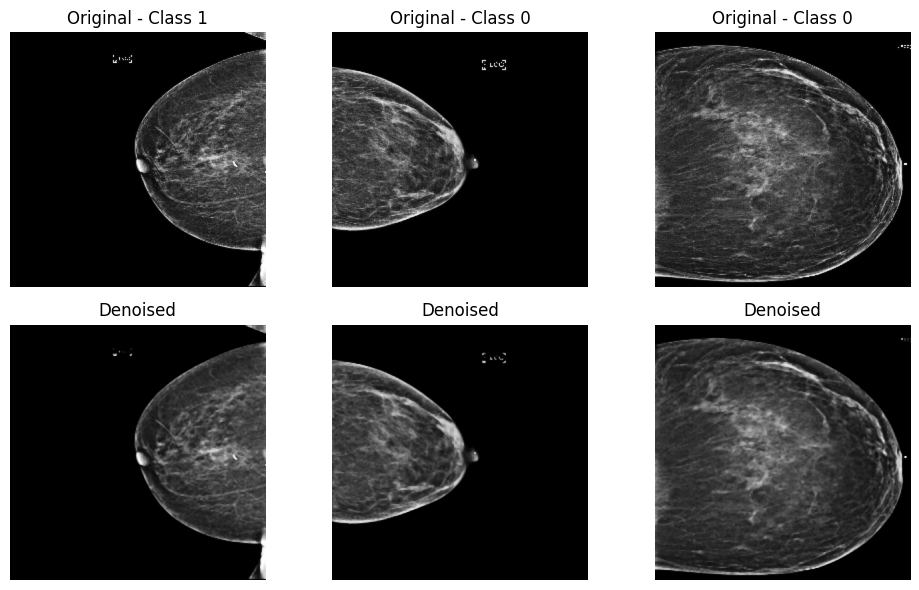

In [21]:
import matplotlib.pyplot as plt
sample = df_balanced.sample(3, random_state=42)

plt.figure(figsize=(10, 6))
for i, (_, row) in enumerate(sample.iterrows()):
    orig = cv2.imread(row['filename'], cv2.IMREAD_GRAYSCALE)
    den = row['denoised']

    plt.subplot(2, 3, i+1)
    plt.imshow(orig, cmap='gray')
    plt.title(f"Original - Class {row['class']}")
    plt.axis('off')

    plt.subplot(2, 3, i+4)
    plt.imshow(den, cmap='gray')
    plt.title("Denoised")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [22]:
import cv2
import numpy as np
from tqdm import tqdm

def apply_clahe(df):
    """
    Applies CLAHE to images that have already been median-blurred.
    Stores the enhanced version in df['enhanced'].
    """
    enhanced_imgs = []
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    for img in tqdm(df['denoised'], desc="Applying CLAHE to median-blurred images"):
        if img is None:
            enhanced_imgs.append(None)
            continue
        # Apply CLAHE (expects grayscale uint8 image)
        enhanced = clahe.apply(img)
        enhanced_imgs.append(enhanced)

    df['enhanced'] = enhanced_imgs
    return df

# Apply on your training dataframe
df_balanced = apply_clahe(df_balanced)


Applying CLAHE to median-blurred images: 100%|██████████| 3138/3138 [00:03<00:00, 869.44it/s]


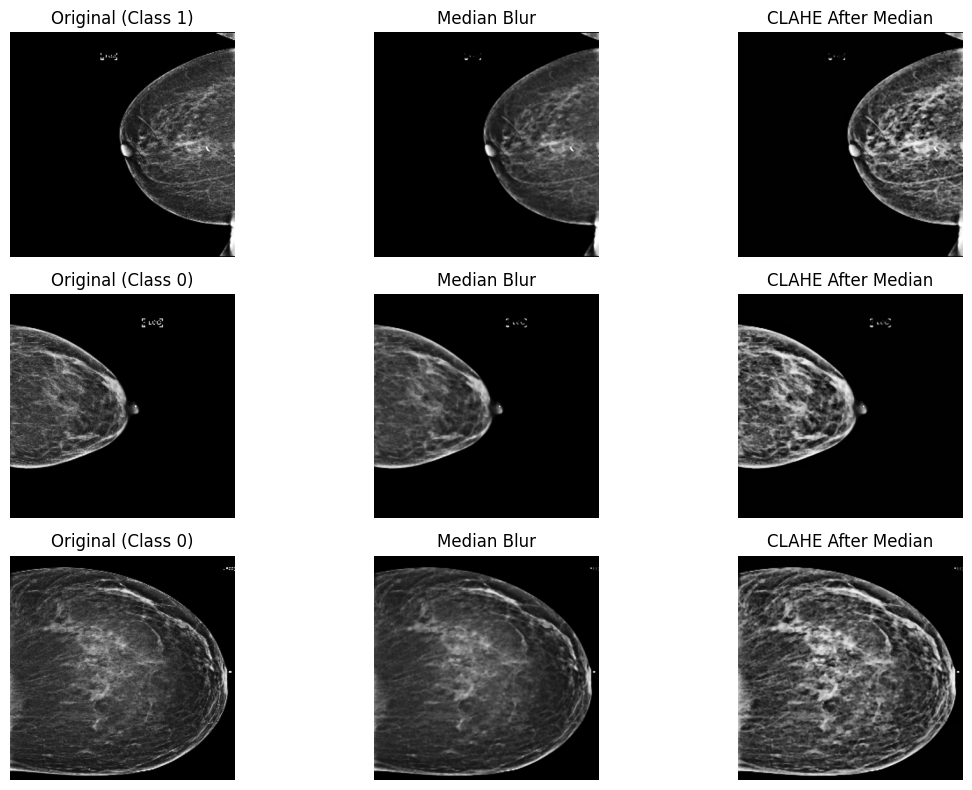

In [23]:
# We'll randomly sample 3 mammograms from your training dataframe
samples = df_balanced.sample(3, random_state=42)

plt.figure(figsize=(12, 8))

for i, (_, row) in enumerate(samples.iterrows()):
    # Read original image
    orig = cv2.imread(row['filename'], cv2.IMREAD_GRAYSCALE)
    
    # Get median-blurred version
    median_img = row['denoised']  # assuming you stored median-blurred in this column

    # Apply CLAHE on top of the median-blurred image
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(median_img)

    # --- Plot Original ---
    plt.subplot(3, 3, i*3 + 1)
    plt.imshow(orig, cmap='gray')
    plt.title(f"Original (Class {row['class']})")
    plt.axis('off')

    # --- Plot Median Blurred ---
    plt.subplot(3, 3, i*3 + 2)
    plt.imshow(median_img, cmap='gray')
    plt.title("Median Blur")
    plt.axis('off')

    # --- Plot CLAHE Enhanced ---
    plt.subplot(3, 3, i*3 + 3)
    plt.imshow(clahe_img, cmap='gray')
    plt.title("CLAHE After Median")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [24]:
from skimage import measure

def segment_tumor(img):
    """
    Perform simple unsupervised segmentation to isolate tumor-like regions.
    img: preprocessed (CLAHE + denoised) grayscale image
    Returns: binary mask and overlay
    """

    # Step 1. Normalize
    img = cv2.resize(img, (224, 224))
    img_blur = cv2.GaussianBlur(img, (5,5), 0)

    # Step 2. Otsu thresholding (adaptive cutoff)
    _, mask = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Step 3. Morphological refinement
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Step 4. Keep only largest connected component (likely tumor)
    labels = measure.label(mask, connectivity=2)
    props = measure.regionprops(labels)

    if len(props) > 0:
        largest = max(props, key=lambda x: x.area)
        mask = (labels == largest.label).astype(np.uint8) * 255

    # Step 5. Overlay mask on original image
    overlay = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    overlay[mask > 0] = [255, 0, 0]  # red overlay on tumor region

    return mask, overlay





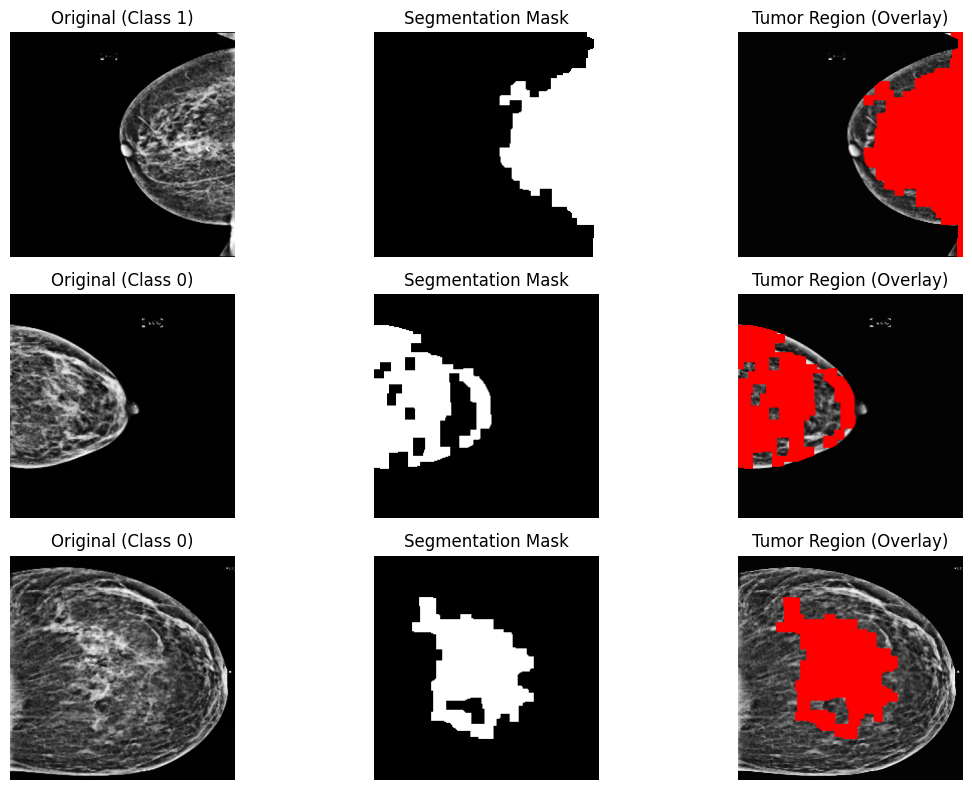

In [25]:
# 🔍 Test it on a few random samples
samples = df_balanced.sample(3, random_state=42)

plt.figure(figsize=(12, 8))
for i, (_, row) in enumerate(samples.iterrows()):
    img = row['enhanced']  # your CLAHE-processed image
    mask, overlay = segment_tumor(img)

    plt.subplot(3, 3, i*3 + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Original (Class {row['class']})")
    plt.axis('off')

    plt.subplot(3, 3, i*3 + 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Segmentation Mask")
    plt.axis('off')

    plt.subplot(3, 3, i*3 + 3)
    plt.imshow(overlay)
    plt.title("Tumor Region (Overlay)")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [26]:
def extract_statistical_features(image):
    """
    Compute statistical texture features from tumor region.
    image: preprocessed grayscale image (CLAHE + denoised)
    Returns: dict of features
    """
    # Step 1: Segment the tumor area
    mask, _ = segment_tumor(image)

    # Resize both to the same size
    if mask.shape != image.shape:
        image = cv2.resize(image, (mask.shape[1], mask.shape[0]))

    # Step 2: Extract the tumor region
    tumor_pixels = image[mask > 0].astype(np.float32)
    if len(tumor_pixels) == 0:
        return {f: 0 for f in ['mean', 'std', 'variance', 'smoothness', 'entropy', 'skewness', 'kurtosis', 'rms']}

    # Step 3: Compute features
    mean_val = np.mean(tumor_pixels)
    std_val = np.std(tumor_pixels)
    var_val = np.var(tumor_pixels)
    rms_val = np.sqrt(np.mean(np.square(tumor_pixels)))
    smoothness = 1 - (1 / (1 + var_val))

    # Entropy (histogram-based)
    hist, _ = np.histogram(tumor_pixels, bins=256, range=(0, 255), density=True)
    hist = hist[hist > 0]
    ent = -np.sum(hist * np.log2(hist))

    from scipy.stats import skew, kurtosis
    skewness = skew(tumor_pixels, bias=False)
    kurt = kurtosis(tumor_pixels, bias=False)

    return {
        'mean': mean_val,
        'std': std_val,
        'variance': var_val,
        'smoothness': smoothness,
        'entropy': ent,
        'skewness': skewness,
        'kurtosis': kurt,
        'rms': rms_val
    }


In [27]:
df_balanced.head()

,filename,class,denoised,enhanced
834,/kaggle/input/breast-cancer-detection/train/0/...,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,..."
1509,/kaggle/input/breast-cancer-detection/train/0/...,0,"[[167, 166, 166, 166, 166, 166, 173, 173, 175,...","[[185, 185, 185, 185, 185, 185, 190, 190, 192,..."
100,/kaggle/input/breast-cancer-detection/train/0/...,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,..."
56,/kaggle/input/breast-cancer-detection/train/0/...,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,..."
1067,/kaggle/input/breast-cancer-detection/train/0/...,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,..."


In [28]:
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
df_balanced['class'].value_counts()

class
1    1569
0    1569
Name: count, dtype: int64

In [29]:
df_balanced.head()

,filename,class,denoised,enhanced
0,/kaggle/input/breast-cancer-detection/train/1/...,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,..."
1,/kaggle/input/breast-cancer-detection/train/0/...,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,..."
2,/kaggle/input/breast-cancer-detection/train/0/...,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,..."
3,/kaggle/input/breast-cancer-detection/train/1/...,1,"[[86, 86, 86, 85, 83, 80, 78, 76, 74, 73, 72, ...","[[91, 91, 91, 89, 85, 78, 74, 69, 65, 62, 60, ..."
4,/kaggle/input/breast-cancer-detection/train/1/...,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,..."


In [30]:
import cv2
import random
import matplotlib.pyplot as plt

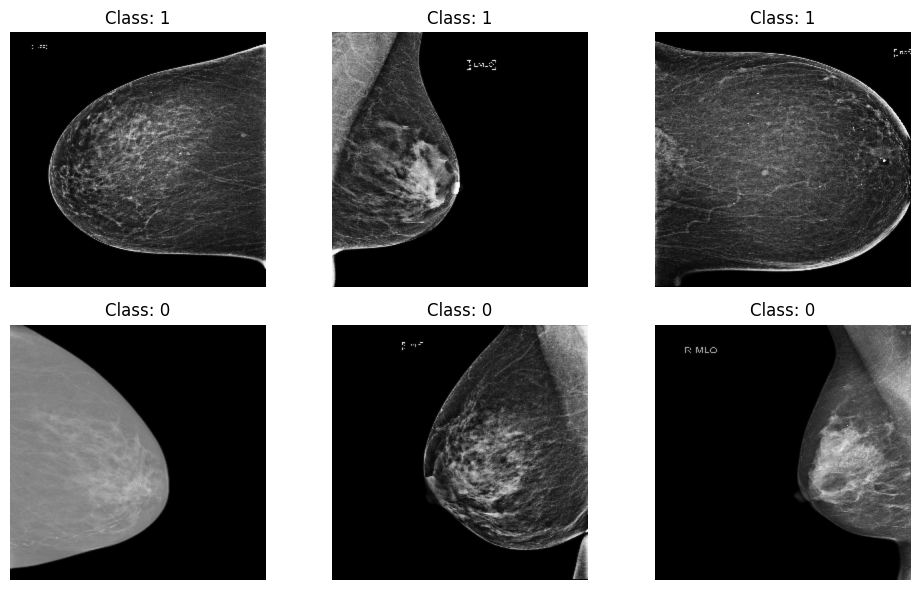

In [31]:
classes = df_balanced['class'].unique()

# Plot samples
plt.figure(figsize=(10, 6))

for i, c in enumerate(classes):
    # Randomly pick 3 images from each class
    samples = df_balanced[df_balanced['class'] == c].sample(3, random_state=42)
    
    for j, path in enumerate(samples['filename']):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(len(classes), 3, i*3 + j + 1)
        plt.imshow(img)
        plt.title(f"Class: {c}")
        plt.axis('off')

plt.tight_layout()
plt.show()

In [55]:
df_balanced.head()

,filename,class,denoised,enhanced
0,/kaggle/input/breast-cancer-detection/train/1/...,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,..."
1,/kaggle/input/breast-cancer-detection/train/0/...,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,..."
2,/kaggle/input/breast-cancer-detection/train/0/...,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,..."
3,/kaggle/input/breast-cancer-detection/train/1/...,1,"[[86, 86, 86, 85, 83, 80, 78, 76, 74, 73, 72, ...","[[91, 91, 91, 89, 85, 78, 74, 69, 65, 62, 60, ..."
4,/kaggle/input/breast-cancer-detection/train/1/...,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,..."


In [56]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_balanced,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=42
)


Found 3138 validated image filenames belonging to 2 classes.


In [33]:
import pandas as pd

def oversample_dataframe(df, label_col='label'):
    # Find counts for each class
    class_counts = df['class'].value_counts()
    max_count = class_counts.max()

    # Oversample each class
    df_list = []
    for cls in class_counts.index:
        cls_df = df[df['class'] == cls]
        if len(cls_df) < max_count:
            # Oversample with replacement
            cls_oversampled = cls_df.sample(max_count, replace=True, random_state=42)
        else:
            cls_oversampled = cls_df
        df_list.append(cls_oversampled)
    
    # Concatenate and shuffle
    balanced_df = pd.concat(df_list).sample(frac=1, random_state=42).reset_index(drop=True)
    return balanced_df

# Usage for validation and test splits
valid_df_balanced = oversample_dataframe(df_valid, label_col='label')
test_df_balanced = oversample_dataframe(df_test, label_col='label')

# Now use valid_df_balanced and test_df_balanced in your generator


In [37]:
def extract_features_from_df(df):
    feature_list = []
    for _, row in df.iterrows():
        img = cv2.imread(row['filename'], cv2.IMREAD_GRAYSCALE)
        features = extract_statistical_features(img)
        features['label'] = int(row['class'])
        feature_list.append(features)
    return pd.DataFrame(feature_list)

# Generate features for all sets
train_features = extract_features_from_df(df_balanced)
valid_features = extract_features_from_df(valid_df_balanced)
test_features = extract_features_from_df(test_df_balanced)

# Save to CSVs
train_features.to_csv("train_features.csv", index=False)
valid_features.to_csv("valid_features.csv", index=False)
test_features.to_csv("test_features.csv", index=False)

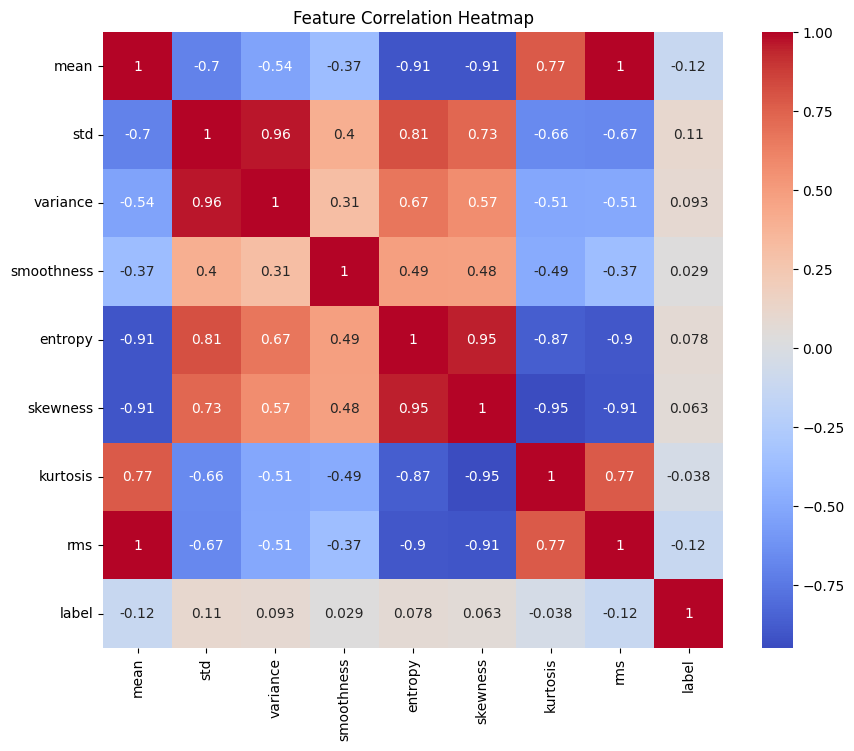

In [38]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(train_features.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated a

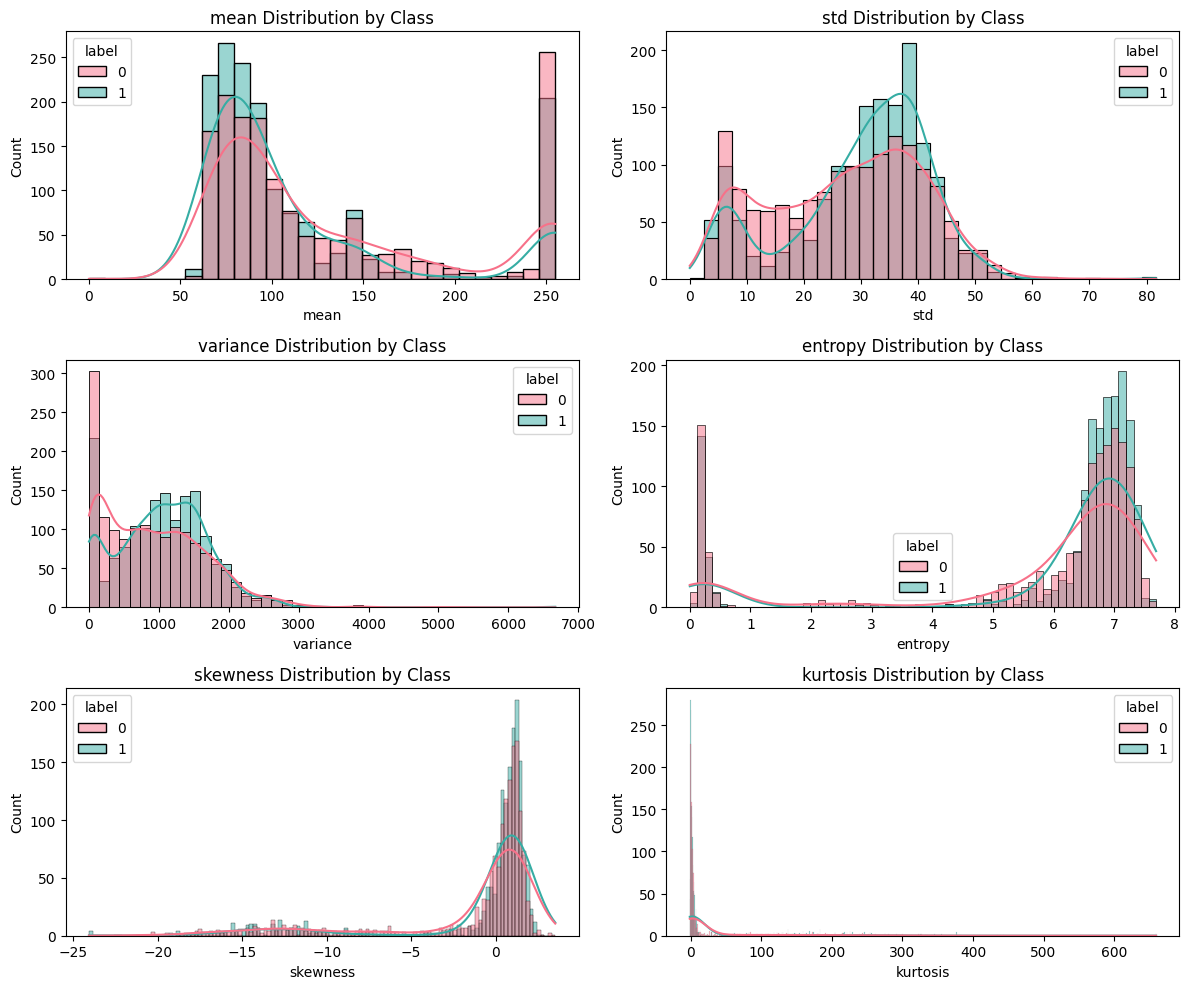

In [39]:
features_to_plot = ['mean', 'std', 'variance', 'entropy', 'skewness', 'kurtosis']

plt.figure(figsize=(12, 10))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data=train_features, x=feature, hue='label', kde=True, palette='husl')
    plt.title(f"{feature} Distribution by Class")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

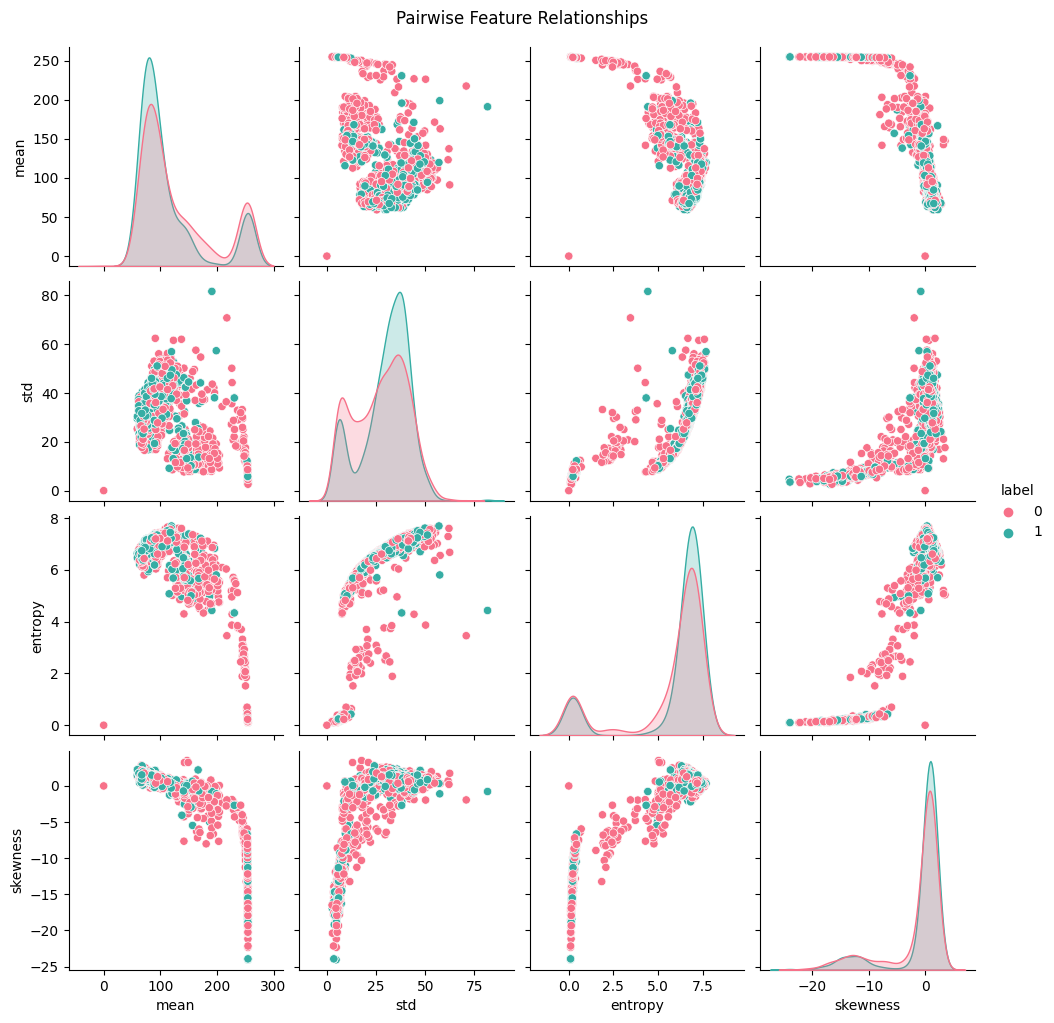

In [40]:
sns.pairplot(train_features[['mean', 'std', 'entropy', 'skewness', 'label']], hue='label', palette='husl')
plt.suptitle("Pairwise Feature Relationships", y=1.02)
plt.show()


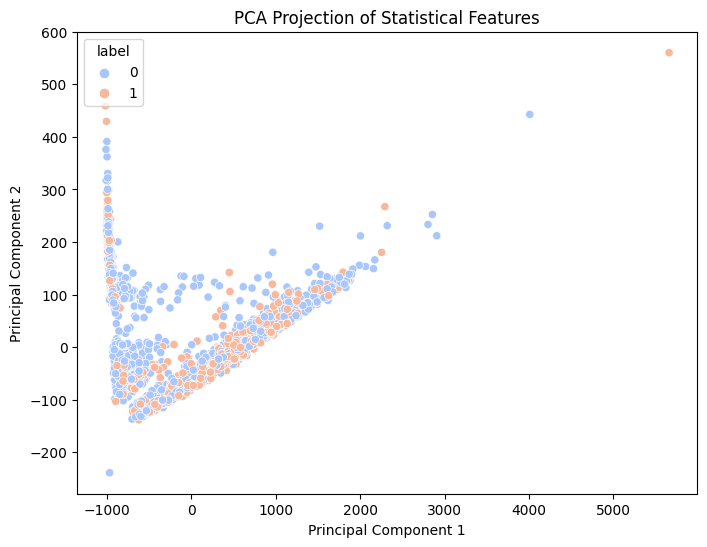

In [41]:
from sklearn.decomposition import PCA

X = train_features.drop(columns=['label'])
y = train_features['label']

pca = PCA(n_components=2)
components = pca.fit_transform(X)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=components[:, 0], y=components[:, 1], hue=y, palette='coolwarm')
plt.title("PCA Projection of Statistical Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


In [42]:
from sklearn.model_selection import train_test_split

# Load
train_df = pd.read_csv("/kaggle/working/train_features.csv")
valid_df = pd.read_csv("/kaggle/working/valid_features.csv")
test_df  = pd.read_csv("/kaggle/working/test_features.csv")

# Combine train + valid for stronger training
data = pd.concat([train_df, valid_df]).reset_index(drop=True)

X = data.drop(columns=['label'])
y = data['label']

X_test = test_df.drop(columns=['label'])
y_test = test_df['label']

In [43]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM (RBF Kernel)": SVC(kernel='rbf', probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\n🚀 Training {name}...")
    model.fit(X_scaled, y)
    y_pred = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

    print(f"\n📊 Confusion Matrix for {name}:\n{confusion_matrix(y_test, y_pred)}")
    print(f"\n📄 Classification Report for {name}:\n{classification_report(y_test, y_pred)}")
    print(f"✅ Accuracy: {acc:.4f}")
    print("-" * 60)



🚀 Training Logistic Regression...

📊 Confusion Matrix for Logistic Regression:
[[ 95 113]
 [ 89 119]]

📄 Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.52      0.46      0.48       208
           1       0.51      0.57      0.54       208

    accuracy                           0.51       416
   macro avg       0.51      0.51      0.51       416
weighted avg       0.51      0.51      0.51       416

✅ Accuracy: 0.5144
------------------------------------------------------------

🚀 Training SVM (RBF Kernel)...

📊 Confusion Matrix for SVM (RBF Kernel):
[[ 82 126]
 [ 62 146]]

📄 Classification Report for SVM (RBF Kernel):
              precision    recall  f1-score   support

           0       0.57      0.39      0.47       208
           1       0.54      0.70      0.61       208

    accuracy                           0.55       416
   macro avg       0.55      0.55      0.54       416
weighted avg       0.55 

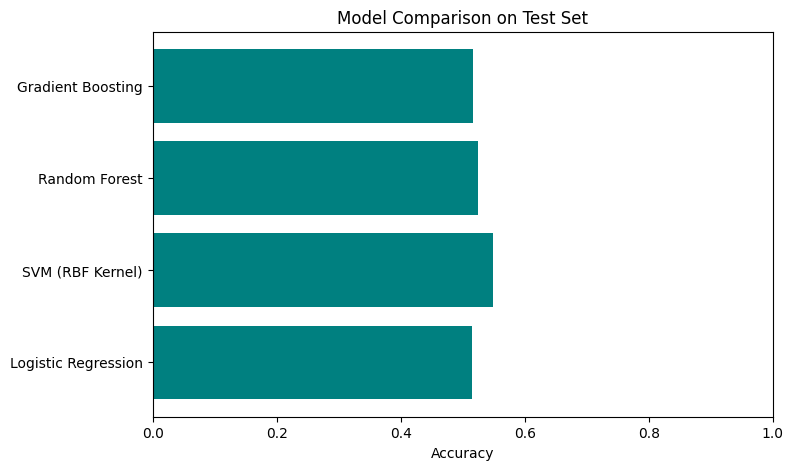

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.barh(list(results.keys()), list(results.values()), color='teal')
plt.xlabel("Accuracy")
plt.title("Model Comparison on Test Set")
plt.xlim(0, 1)
plt.show()

Train: {'1': 1569, '0': 1569}
Valid: {'1': 448, '0': 448}
Test: {'0': 208, '1': 208}


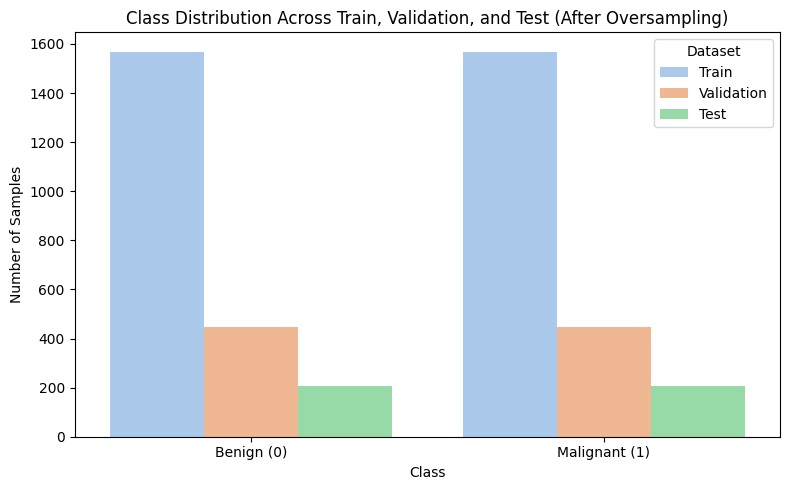

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Example DataFrames (already created)
# df_train, df_valid, df_test, df_balanced

# Optional: verify class counts
print("Train:", df_balanced['class'].value_counts().to_dict())
print("Valid:", valid_df_balanced['class'].value_counts().to_dict())
print("Test:", test_df_balanced['class'].value_counts().to_dict())

# Combine all for plotting
df_train_plot = df_balanced.copy()
df_train_plot['set'] = 'Train'

df_valid_plot = valid_df_balanced.copy()
df_valid_plot['set'] = 'Validation'

df_test_plot = test_df_balanced.copy()
df_test_plot['set'] = 'Test'

df_all = pd.concat([df_train_plot, df_valid_plot, df_test_plot])

# Plot
plt.figure(figsize=(8, 5))
sns.countplot(data=df_all, x='class', hue='set', palette='pastel')

plt.title("Class Distribution Across Train, Validation, and Test (After Oversampling)")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks([0, 1], ["Benign (0)", "Malignant (1)"])
plt.legend(title="Dataset", loc='upper right')
plt.tight_layout()
plt.show()


In [47]:
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df_balanced,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)


Found 896 validated image filenames belonging to 2 classes.


In [48]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df_balanced,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

Found 416 validated image filenames belonging to 2 classes.


In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow import keras

In [52]:
# Initialize a Sequential model
model = Sequential()

# First convolutional layer with 100 filters of size 3x3, using ReLU activation
# The input shape is set to 224x224 pixels with 3 color channels (RGB)
model.add(Conv2D(100, (3, 3), activation="relu", input_shape=(224, 224, 3)))

# First max pooling layer to reduce spatial dimensions (down-sampling by half)
model.add(MaxPooling2D(2, 2))

# Second convolutional layer with 100 filters of size 3x3, using ReLU activation
model.add(Conv2D(100, (3, 3), activation="relu"))

# Second max pooling layer for further down-sampling
model.add(MaxPooling2D(2, 2))

# Third convolutional layer with 64 filters of size 3x3, using ReLU activation
model.add(Conv2D(64, (3, 3), activation="relu"))

# Fourth convolutional layer, also with 64 filters of size 3x3, using ReLU activation
model.add(Conv2D(64, (3, 3), activation="relu"))

# Third max pooling layer to further reduce spatial dimensions
model.add(MaxPooling2D(2, 2))

# Flatten the feature maps into a 1D vector for the fully connected layers
model.add(Flatten())

# First fully connected layer with 64 units and ReLU activation
model.add(Dense(64, activation="relu"))

# Dropout layer to randomly set 20% of the inputs to zero, preventing overfitting
model.add(Dropout(.2))

# Second fully connected layer with 32 units and ReLU activation
model.add(Dense(32, activation="relu"))

# Dropout layer to randomly set 30% of the inputs to zero, for further regularization
model.add(Dropout(.3))

# Third fully connected layer with 32 units and ReLU activation
model.add(Dense(32, activation="relu"))

# Output layer with 1 unit and sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model with Adam optimizer and binary cross-entropy loss for binary classification
# Use accuracy as the evaluation metric
model.compile(keras.optimizers.Adam(learning_rate=0.0001), 'binary_crossentropy', metrics=['accuracy'])

# Display the model summary for an overview of the layers and parameters
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1761988452.432398      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761988452.433117      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 100)  │         2,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 100)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 100)  │        90,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        57,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,560,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,750,725 (10.49 MB)

 Trainable params: 2,750,725 (10.49 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
callbacks = [
    # Stop training when validation loss stops improving
    EarlyStopping(
        monitor='val_loss', 
        patience=5, 
        restore_best_weights=True
    ),
    # Save the best model to file
    ModelCheckpoint(
        'best_model.h5', 
        monitor='val_loss', 
        save_best_only=True, 
        verbose=1
    ),
    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2, 
        patience=3, 
        min_lr=1e-6, 
        verbose=1
    )
]


In [57]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    callbacks=callbacks,
    epochs=30,    
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1761988536.768631     110 service.cc:148] XLA service 0x793e4000a2c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761988536.769897     110 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761988536.769919     110 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761988537.268134     110 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/99 ━━━━━━━━━━━━━━━━━━━━ 22:28 14s/step - accuracy: 0.5312 - loss: 0.6929

I0000 00:00:1761988546.498299     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.4928 - loss: 0.6938
Epoch 1: val_loss improved from inf to 0.69127, saving model to best_model.h5
99/99 ━━━━━━━━━━━━━━━━━━━━ 60s 468ms/step - accuracy: 0.4929 - loss: 0.6938 - val_accuracy: 0.5379 - val_loss: 0.6913 - learning_rate: 1.0000e-04
Epoch 2/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.5101 - loss: 0.6919
Epoch 2: val_loss improved from 0.69127 to 0.68984, saving model to best_model.h5
99/99 ━━━━━━━━━━━━━━━━━━━━ 41s 408ms/step - accuracy: 0.5101 - loss: 0.6919 - val_accuracy: 0.5312 - val_loss: 0.6898 - learning_rate: 1.0000e-04
Epoch 3/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.5317 - loss: 0.6904
Epoch 3: val_loss did not improve from 0.68984
99/99 ━━━━━━━━━━━━━━━━━━━━ 40s 405ms/step - accuracy: 0.5317 - loss: 0.6904 - val_accuracy: 0.5201 - val_loss: 0.6913 - learning_rate: 1.0000e-04
Epoch 4/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.5530 - loss: 0.6845
Epoch 4: val_loss did 

In [58]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.3f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.4841 - loss: 0.6939
Test Accuracy: 0.476


In [59]:
from sklearn.metrics import classification_report

y_true = valid_generator.classes
y_pred = (model.predict(valid_generator) > 0.5).astype("int32")
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
print(cm)

28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step
              precision    recall  f1-score   support

           0       0.51      0.25      0.33       448
           1       0.50      0.77      0.61       448

    accuracy                           0.51       896
   macro avg       0.51      0.51      0.47       896
weighted avg       0.51      0.51      0.47       896

[[110 338]
 [104 344]]


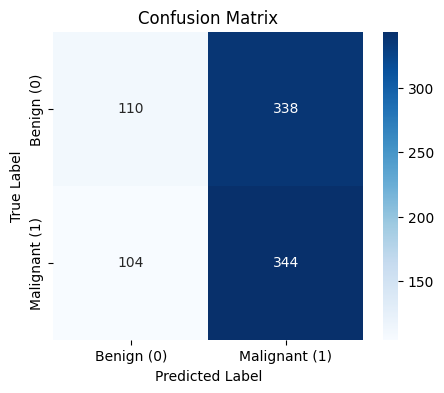

In [60]:
# from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

# Optionally plot it for clarity
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign (0)', 'Malignant (1)'], 
            yticklabels=['Benign (0)', 'Malignant (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [61]:
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense

In [62]:
def build_pretrained_model(base_model):
    base_model.trainable = True
    for layer in base_model.layers[:-20]:  # keep early layers frozen
        layer.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [63]:
models = {
    "VGG16": VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    "ResNet50": ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    "EfficientNetB0": EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
}


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [64]:
for name, base_model in models.items():
    print(f"\n🚀 Training {name}...")
    model = build_pretrained_model(base_model)
    
    history = model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=10,
        callbacks=callbacks,
        verbose=1
    )
    model.save(f"/kaggle/working/{name}_best_model.h5")
    
    val_acc = max(history.history['val_accuracy'])
    print(f"✅ {name} Best Validation Accuracy: {val_acc:.4f}")
    print("-" * 50)


🚀 Training VGG16...
Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.4899 - loss: 2.0177
Epoch 1: val_loss did not improve from 0.68984
99/99 ━━━━━━━━━━━━━━━━━━━━ 106s 679ms/step - accuracy: 0.4899 - loss: 2.0077 - val_accuracy: 0.5000 - val_loss: 0.6933 - learning_rate: 0.0010
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.4796 - loss: 0.6936
Epoch 2: val_loss did not improve from 0.68984
99/99 ━━━━━━━━━━━━━━━━━━━━ 49s 495ms/step - accuracy: 0.4796 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.5015 - loss: 0.6932
Epoch 3: val_loss did not improve from 0.68984
99/99 ━━━━━━━━━━━━━━━━━━━━ 49s 489ms/step - accuracy: 0.5015 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.4929 - loss: 0.6932
Epoch 4: val_loss did not improve from 0.68984
99/99 ━━━━━━━━━━━━━━

28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step

📊 Confusion Matrix for VGG16:
[[  0 448]
 [  0 448]]

📄 Classification Report for VGG16:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       448
           1       0.50      1.00      0.67       448

    accuracy                           0.50       896
   macro avg       0.25      0.50      0.33       896
weighted avg       0.25      0.50      0.33       896



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


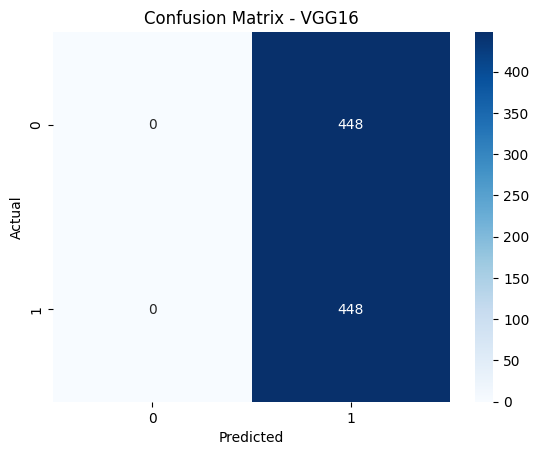

28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step

📊 Confusion Matrix for ResNet50:
[[296 152]
 [263 185]]

📄 Classification Report for ResNet50:
              precision    recall  f1-score   support

           0       0.53      0.66      0.59       448
           1       0.55      0.41      0.47       448

    accuracy                           0.54       896
   macro avg       0.54      0.54      0.53       896
weighted avg       0.54      0.54      0.53       896



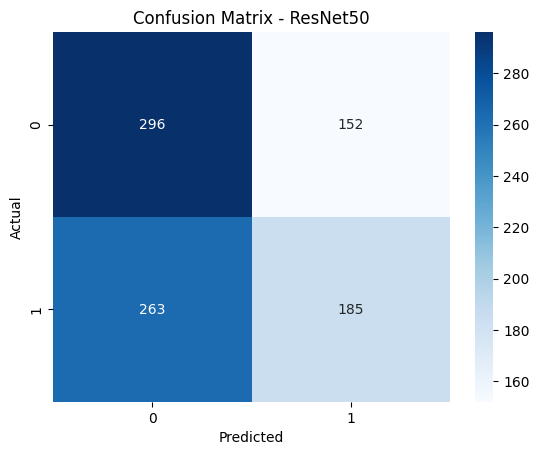

28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step

📊 Confusion Matrix for EfficientNetB0:
[[ 88 360]
 [ 81 367]]

📄 Classification Report for EfficientNetB0:
              precision    recall  f1-score   support

           0       0.52      0.20      0.29       448
           1       0.50      0.82      0.62       448

    accuracy                           0.51       896
   macro avg       0.51      0.51      0.45       896
weighted avg       0.51      0.51      0.45       896



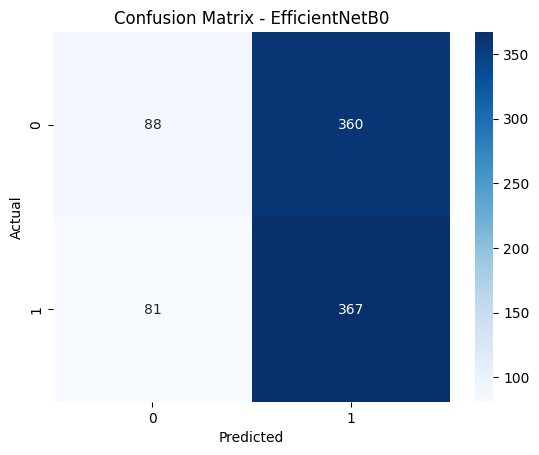

In [65]:
from tensorflow.keras.models import load_model
for name in ["VGG16", "ResNet50", "EfficientNetB0"]:
        model = load_model(f"/kaggle/working/{name}_best_model.h5")
    
        y_true = valid_generator.classes
        y_pred = (model.predict(valid_generator) > 0.5).astype("int32")

        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        print(f"\n📊 Confusion Matrix for {name}:\n{cm}")

        # Classification Report
        report = classification_report(
            y_true, y_pred,
            target_names=list(valid_generator.class_indices.keys())
        )
        print(f"\n📄 Classification Report for {name}:\n{report}")

        # Optional — visualize confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"Confusion Matrix - {name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

print("=" * 80)